# A Bottom-up Approach to Complex Rhythms

In [1]:
%load_ext abjadext.ipython
import abjad

In [2]:
import random
durations = []
numerators = range(16)
denominators = [2**x for x in range(1, 5)]
for x in range(10):
    numerator = random.choice(numerators)
    denominator = random.choice(denominators)
    duration_token = (numerator, denominator)
    duration = abjad.Duration(duration_token)
    durations.append(duration)

for d in durations:
    print(d)

3/4
2
13/4
1/4
7/2
5
1
5/4
3/4
0


Assignability is a thing:

In [5]:
duration = abjad.Duration(5,4)
note = abjad.Note(0, (duration))

AssignabilityError: not assignable duration: Duration(5, 4).

The `LeafMaker` class helps us around the assignability error:

In [6]:
maker = abjad.LeafMaker()
pitches = [None]
durations = [abjad.Duration(3, 8), abjad.Duration(5, 8)]
leaves = maker(pitches, durations)
leaves

Selection([Rest('r4.'), Rest('r2'), Rest('r8')])

# Tuplets

Use the `Tuplet` class to make tuplets (of any non-binary division). The Tuplet class provides an interface for working with complex rhythms in a bottom-up way:

In [7]:
tuplet = abjad.Tuplet(abjad.Multiplier(2, 3), "c'8 d'8 e'8")

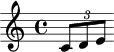

In [8]:
abjad.show(tuplet)

You can also pack existing leaves into a Tuplet instance.

In [9]:
leaves = [abjad.Note("fs'8"), abjad.Note("g'8"), abjad.Rest('r8')]

In [10]:
tuplet = abjad.Tuplet(abjad.Multiplier(2, 3), leaves)

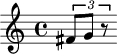

In [11]:
abjad.show(tuplet)

Tuplet instances all have a multiplier and components.

In [12]:
tuplet

Tuplet(Multiplier(2, 3), "fs'8 g'8 r8")

## Understanding Augmentation and Diminution

Remember that any tuplet can be represented as an augmentation or a diminution relative to the written notes' default values. Our example tuplet's multiplier of (2,3) for three eighth notes means that each written eighth note lasts for 2/3rds its written value. Because the original durations have been reduced, this is a diminution:

In [13]:
tuplet.is_diminution

True

A tuplet with a multiplier greater than 1, on the other hand, would be an augmentation:

In [14]:
tuplet = abjad.Tuplet((4,3), "fs'16 g'16 r16")

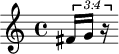

In [15]:
abjad.show(tuplet)


This last tuplet is an augmentation in which each of the written sixteenth notes lasts for 4/3rds of its written duration. The sounding result would be identical, and these are just two ways of writing the same thing, the former of which happens to be conventional.

Remember that object-oriented programming gives us objects with characteristics and behaviors. We can use the dot-chaining syntax to read and write the tuplet's multiplier attribute:

In [16]:
tuplet = abjad.Tuplet(abjad.Multiplier(2, 3), "fs'8 g' r8")

In [17]:
tuplet.multiplier

Multiplier(2, 3)

In [18]:
tuplet.multiplier = abjad.Multiplier(4, 5)

In [19]:
tuplet

Tuplet(Multiplier(4, 5), "fs'8 g'8 r8")

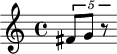

In [20]:
abjad.show(tuplet)

## Adding Leaves

The multiplier is a reasonable characteristic for our tuplet to have, but what about behaviors? Well, you probably want to be able to build up tuplets by adding leaves to them, one or several a time. The append method adds leaves to the end of a tuplet (and to any Python list), one leaf at a time:

In [21]:
tuplet.append(abjad.Note("e'4."))

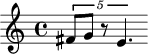

In [22]:
abjad.show(tuplet)

...or using a LilyPond string:

In [23]:
tuplet.append("bf8")

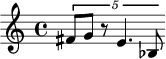

In [24]:
abjad.show(tuplet)

Likewise, the extend method adds two or more leaves at a time:

In [25]:
notes = [abjad.Note("fs'32"), abjad.Note("e'32"), abjad.Note("d'32"), abjad.Rest((1, 32))]

In [26]:
tuplet.extend(notes)

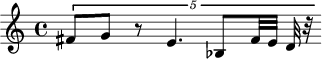

In [27]:
abjad.show(tuplet)

And you can use a LilyPond string with extend, too:

In [28]:
tuplet.extend("gs'8 a8")

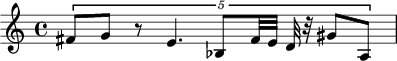

In [29]:
abjad.show(tuplet)

## Removing Leaves

You can remove tuplet components by reference using the remove method:

In [30]:
tuplet.remove(tuplet[3])

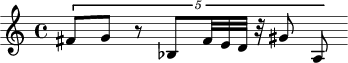

In [31]:
abjad.show(tuplet)

If you want to remove a component by index and then keep it to do something else with it, use the pop method instead of remove:

In [32]:
popped = tuplet.pop(2)
popped

Rest('r8')

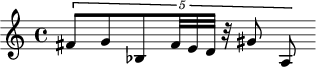

In [33]:
abjad.show(tuplet)

## Indexing Leaves

Tuplets support indexing, if you'd like to do something to the nth component of a tuplet:

In [34]:
tuplet[1]

Note("g'8")

If you've added an existing list to a tuplet's components, and you'd like to see where a component of that list is in the tuplet, you can use the tuplet's index method - in our case, we'll use our notes list from above:

In [35]:
notes

[Note("fs'32"), Note("e'32"), Note("d'32"), Rest('r32')]

In [36]:
notes[1]

Note("e'32")

In [37]:
tuplet.index(notes[1]) # Where is the second element of notes in tuplet?

4

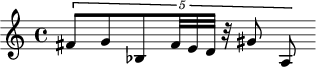

In [38]:
abjad.show(tuplet) # it's at index 4

## Making Tuplets from Durations and Ratios

The Tuplet class also provides a method for constructing a tuplet from a duration and a ratio, where the ratio is a list of integers, the sum of which determines the number of equally spaced pulses within the duration:

In [39]:
tuplet = abjad.Tuplet()
tuplet = abjad.Tuplet.from_duration_and_ratio((1,4), [1,3,1])

In [40]:
staff = abjad.Staff([tuplet], context_name='RhythmicStaff')

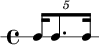

In [41]:
abjad.show(staff)

This might not seem like much, but we can write functions that use these kinds of basic functionalities to do more complicated things, like we'll do in this next example, taken from a real score:

# Brian Ferneyhough - Unsichtbare Farben 

Mikhial Malt analyzes the rhythmic materials of Ferneyhough’s solo violin composition, Unsichtbare Farben, in The OM Composer’s Book 2.

Malt explains that Ferneyhough used OpenMusic to create an “exhaustive catalogue of rhythmic cells” such that:

Each cell consists of the same duration divided into two pulses related by a durational proportion ranging from 1:1 to 1:11.

The second pulse is then subdivided successively into 1, 2, 3, 4, 5 and 6 equal parts.

Let’s recreate Malt’s results in Abjad.

## The Proportions 

We use a list comprehension to describe a list of (1,n) tuples, each of which will describe the durational proportion between a cell's first and second pulse:

In [42]:
proportions = [(1, n) for n in range(1, 11 + 1)]

In [43]:
proportions

[(1, 1),
 (1, 2),
 (1, 3),
 (1, 4),
 (1, 5),
 (1, 6),
 (1, 7),
 (1, 8),
 (1, 9),
 (1, 10),
 (1, 11)]

## The Transforms

Next we’ll show how to divide a quarter note into various ratios, and then divide the final logical tie of the resulting tuplet into yet another ratio:

In [44]:
def make_nested_tuplet(
    tuplet_duration,
    outer_tuplet_proportions,
    inner_tuplet_subdivision_count,
    ):
    r'''Makes nested tuplet.
    '''

    outer_tuplet = abjad.Tuplet.from_duration_and_ratio(
        tuplet_duration, outer_tuplet_proportions)
    inner_tuplet_proportions = inner_tuplet_subdivision_count * [1]    
    last_leaf = next(abjad.iterate(outer_tuplet).by_leaf(reverse=True))
    right_logical_tie = abjad.inspect(last_leaf).get_logical_tie()
    right_logical_tie.to_tuplet(inner_tuplet_proportions)
    return outer_tuplet

And of course it's easier to see what this function does with an example of use:

In [45]:
tuplet = make_nested_tuplet(abjad.Duration(1, 4), (1, 1), 5)

In [46]:
staff = abjad.Staff([tuplet], context_name='RhythmicStaff')

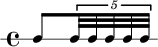

In [47]:
abjad.show(staff)

We see that a duration of a quarter note (the first argument) has been divided into two pulses with a durational proportion of 1:1 (second argument), the second pulse of which has then been divided into five equally spaced parts (the third argument). Try changing the arguments and see what happens.

In [48]:
tuplet = make_nested_tuplet(abjad.Duration(1, 4), (13, 28), 11)

In [49]:
staff = abjad.Staff([tuplet], context_name='RhythmicStaff')

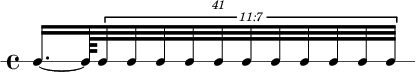

In [50]:
abjad.show(staff)

In [51]:
tuplet = make_nested_tuplet(abjad.Duration(1, 4), (3, 1), 5)

In [52]:
staff = abjad.Staff([tuplet], context_name='RhythmicStaff')

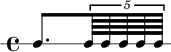

In [53]:
abjad.show(staff)

### Logical Ties Solve the Problem of Five

A logical tie is a selection of notes or chords connected by ties. It lets us talk about a notated rhythm of 5/16, for example, which can not be expressed with only a single leaf.

Note how we can divide a tuplet whose outer proportions are 3/5, where the second logical tie requires two notes to express the 5/16 duration:

In [54]:
outer_tuplet = abjad.Tuplet.from_duration_and_ratio(abjad.Duration(1, 4), (3, 5))

In [55]:
staff = abjad.Staff([outer_tuplet], context_name='RhythmicStaff')

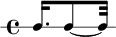

In [56]:
abjad.show(staff)

In [57]:
subdivided_tuplet = make_nested_tuplet(abjad.Duration(1, 4), (3, 5), 3)

In [58]:
staff = abjad.Staff([subdivided_tuplet], context_name='RhythmicStaff')

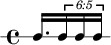

In [59]:
abjad.show(staff)

Do you see which objects and methods in our make_nested_tuplet function convert a logical tie into a tuplet?

## The Rhythms

Now that we know how to make the basic building block, let’s make a lot of tuplets all at once.

We’ll set the duration of each tuplet equal to a quarter note:

In [60]:
duration = abjad.Fraction(1,4)

Reusing our make_nested_tuplet function, we make one row of rhythms, with the last logical tie increasingly subdivided:

In [61]:
def make_row_of_nested_tuplets(
    tuplet_duration,
    outer_tuplet_proportions,
    column_count,
    ):
    r'''Makes row of nested tuplets.
    '''

    assert 0 < column_count
    row_of_nested_tuplets = []
    for n in range(column_count):
        inner_tuplet_subdivision_count = n + 1
        nested_tuplet = make_nested_tuplet(
            tuplet_duration,
            outer_tuplet_proportions,
            inner_tuplet_subdivision_count,
            )
        row_of_nested_tuplets.append(nested_tuplet)
    return row_of_nested_tuplets

In [62]:
tuplets = make_row_of_nested_tuplets(duration, (2, 1), 6)

In [63]:
staff = abjad.Staff(tuplets, context_name='RhythmicStaff')

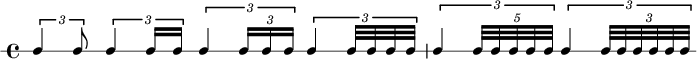

In [64]:
abjad.show(staff)

If we can make one single row of rhythms, we can make many rows of rhythms. We reuse this last function to make another function:

In [65]:
def make_rows_of_nested_tuplets(tuplet_duration, row_count, column_count):
    r'''Makes rows of nested tuplets.
    '''

    assert 0 < row_count
    rows_of_nested_tuplets = []
    for n in range(row_count):
        outer_tuplet_proportions = (1, n + 1)
        row_of_nested_tuplets = make_row_of_nested_tuplets(
            tuplet_duration, outer_tuplet_proportions, column_count)
        rows_of_nested_tuplets.append(row_of_nested_tuplets)
    return rows_of_nested_tuplets

In [66]:
score = abjad.Score()

In [67]:
for tuplet_row in make_rows_of_nested_tuplets(duration, 10, 6):
    score.append(abjad.Staff(tuplet_row, context_name='RhythmicStaff'))

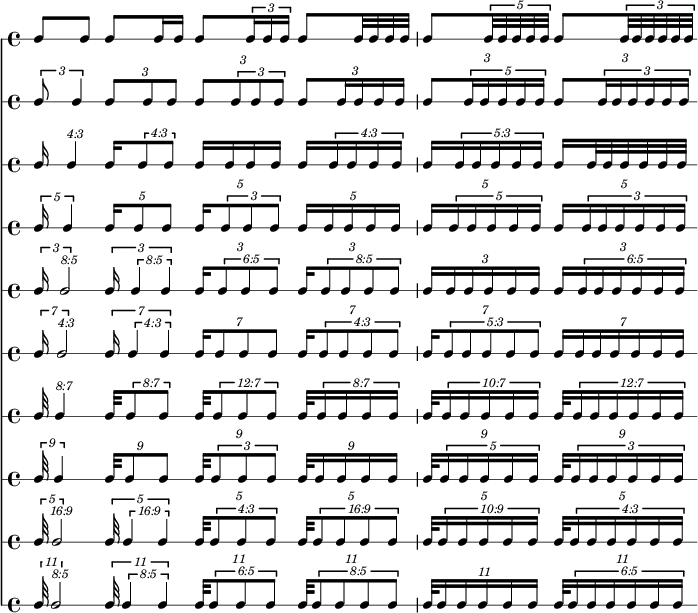

In [68]:
abjad.show(score)

This example illustrates how simpler bottom-up rhythmic construction might be abstracted to explore the potential of a bottom-up rhythmic idea.

# Meter

In [69]:
### Chopping Durations with Durations

It's easy to make durations that don't neatly fit into a particular time signature:

In [70]:
staff = abjad.Staff("c'4. c'4. c'4. c'4. c'4. c'4. c'4. c'4.")
abjad.f(staff)

\new Staff {
    c'4.
    c'4.
    c'4.
    c'4.
    c'4.
    c'4.
    c'4.
    c'4.
}


Let's make this metrically legible by chopping the leaves every whole note using `mutate().split()`. 

Note that this function returns selections full of the kind of component you split: if you want to split leaves in place, pass in `staff[:]`, and if you want to return `Selection`s containing new `Staff`s, pass in `staff`.

To keep splitting by the same duration until we get through all of the leaves, set the keyword argument cyclic equal to `True`.

In [71]:
abjad.mutate(staff[:]).split([abjad.Duration(4,4)], cyclic=True)
abjad.f(staff)

\new Staff {
    c'4.
    c'4.
    c'4 ~
    c'8
    c'4.
    c'4.
    c'8 ~
    c'4
    c'4.
    c'4.
}


This is better -- the music now plays nice with LilyPond's barlines and isn't incorrectly notated -- but in Python, we still don't have any `Measure` objects, and our staff still iterates through leaves:

In [72]:
for leaf in staff[:5]:
    print(leaf)

c'4.
c'4.
c'4
c'8
c'4.


What should we do if we want to iterate through our music measure by measure?

### Wrapping Leaves in Measures

We can create `Measure` objects by wrapping each split `Selection` in a `Measure`:

In [73]:
duration = abjad.Duration(4,4)
for shard in abjad.mutate(staff[:]).split([duration] , cyclic=True):
    abjad.mutate(shard).wrap(abjad.Measure())
abjad.f(staff)

\new Staff {
    {
        \time 4/4
        c'4.
        c'4.
        c'4 ~
    }
    {
        c'8
        c'4.
        c'4.
        c'8 ~
    }
    {
        c'4
        c'4.
        c'4.
    }
}


Now we have measures in our score tree, and our staff will iterate through measures by default.

In [74]:
for measure in staff:
    print(measure)

Measure((4, 4), "c'4. c'4. c'4 ~")
Measure((4, 4), "c'8 c'4. c'4. c'8 ~")
Measure((4, 4), "c'4 c'4. c'4.")


If we want to iterate by leaves, now we need to use `abjad.iterate()`.

In [75]:
for leaf in abjad.iterate(staff).by_leaf():
    print(leaf)

c'4.
c'4.
c'4
c'8
c'4.
c'4.
c'8
c'4
c'4.
c'4.


### Rewriting Rhythms with Metric Hierarchies

This is looking better, but the internal rhythms of our music still fail to comport with conventions of notation that dictate that we should always show beat three in a measure of (4,4). To do this, we need to impose a hierarchical model of meter onto our music, measure by measure.

In [76]:
four = abjad.Meter()
for measure in staff:
    abjad.mutate(measure).rewrite_meter(four)
abjad.f(staff)

\new Staff {
    {
        \time 4/4
        c'4.
        c'4.
        c'4 ~
    }
    {
        c'8
        c'4.
        c'4.
        c'8 ~
    }
    {
        c'4
        c'4.
        c'4.
    }
}


This didn't change anything, because Abjad's default (4,4) hierarchy is just four quarter notes:

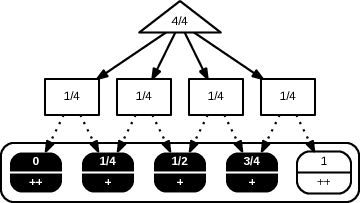

In [77]:
abjad.graph(four)

We need to define a custom meter that includes another level of metric hierarchy and rewrite according to that. To do this, we'll use IRCAM's rhythm tree syntax:

In [78]:
other_four = abjad.Meter('(4/4 ((2/4 (1/4 1/4)) (2/4 (1/4 1/4)) ))')
for measure in staff:
    abjad.mutate(measure).rewrite_meter(other_four)
abjad.f(staff)

\new Staff {
    {
        \time 4/4
        c'4.
        c'8 ~
        c'4
        c'4 ~
    }
    {
        c'8
        c'4.
        c'4.
        c'8 ~
    }
    {
        c'4
        c'4 ~
        c'8
        c'4.
    }
}


This works, because our new meter contains a second level of metric hierarchy.

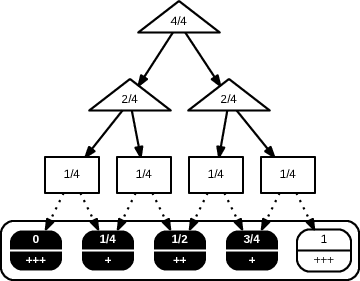

In [79]:
abjad.graph(other_four)

Now you can start to model your metric habits. For further useful customizations, including dot-count, see [`MutationAgent.rewrite_meter()`](http://abjad.mbrsi.org/api/tools/agenttools/MutationAgent.html#abjad.tools.agenttools.MutationAgent.MutationAgent.rewrite_meter).